In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [44]:
data = pd.read_csv("heart_2020_cleaned.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [45]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [46]:
data.shape

(319795, 18)

In [47]:
#...Distribution of continuous variables...#

In [48]:
#...Distribution of categorical variables...#

In [49]:
#...Association of the response with the predictors...#

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [50]:
#...Code with comments...#

Making Dummy Variables

*by Candy Tantichirasakul and Annika Le*

In [51]:
data.replace("Yes", 1, inplace = True)
data.replace("No", 0, inplace = True)
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0,1,Very good,8.0,0,0,0


In [52]:
data['Diabetic'].unique()

array([1, 0, 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

In [53]:
data.replace("Yes (during pregnancy)", 1, inplace = True)
data.replace("No, borderline diabetes", 0, inplace = True)

In [54]:
data["Sex"].unique()

array(['Female', 'Male'], dtype=object)

In [55]:
data.replace("Female", 1, inplace = True)
data.replace("Male", 0, inplace = True)

In [56]:
# Make dummies for categorical variables
# Replace columns with special characters "-", "/" or " "

def makeDummies(data):
    data = pd.concat([data, pd.get_dummies(data['Race'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['AgeCategory'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['GenHealth'])], axis=1)
    #remove last category to avoid multicollinearity
    data = data.drop(columns=['Race', 'Other','AgeCategory','80 or older', 'GenHealth', "Excellent"])
    data.rename(columns={"18-24": "Age1", "25-29": "Age2", "30-34": "Age3","35-39": "Age4","40-44": "Age5","45-49": "Age6","50-54": "Age7","55-59": "Age8","60-64": "Age9","65-69": "Age10","70-74": "Age11","75-79": "Age12"}, inplace = True)
    data.rename(columns={"Very good": "Verygood", "American Indian/Alaskan Native": "AmericanIndianAlaskanNative"}, inplace = True)
    return data

In [57]:
data = makeDummies(data)
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,...,Age7,Age8,Age9,Age10,Age11,Age12,Fair,Good,Poor,Verygood
0,0,16.60,1,0,0,3.0,30.0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


SMOTE

*by Annika Le*

In [58]:
X = data[['BMI', 'Smoking', 'AlcoholDrinking','MentalHealth', "Stroke", "Sex",'PhysicalHealth', "DiffWalking", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer", "Age1", "Age2", "Age3", "Age4", "Age5", "Age6", "Age7", "Age8", "Age9", "Age10", "Age11", "Age12", "White", "Black", "Asian", "AmericanIndianAlaskanNative", "Hispanic", "Poor", "Fair", "Good", "Verygood"]]
y = data.HeartDisease

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [60]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
oversampled = SMOTE(random_state=0)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [61]:
train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

In [62]:
train_smote[train_smote.HeartDisease == 1].count()[0]

204695

In [63]:
train_smote[train_smote.HeartDisease == 1].count()[1]

204695

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [7]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [8]:
######-----------Shuffling the dataset for K-fold------------#########

In [9]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis


Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Baseline Model

In [94]:
model = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)+(Verygood+Fair+Good+Poor)+Asthma+Smoking+Diabetic+KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()

Optimization terminated successfully.
         Current function value: 0.353175
         Iterations 9


In [95]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               409390
Model:                          Logit   Df Residuals:                   409354
Method:                           MLE   Df Model:                           35
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.4905
Time:                        12:42:54   Log-Likelihood:            -1.4459e+05
converged:                       True   LL-Null:                   -2.8377e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.5626      0.043    105.123      0.000       4.478       4.648
Age1                           -7.1262      0.093    -76.407      0.000      -7.309      -6.943
Age2                           -6.8080      0.088    -77.668      0.000      -6.980      -6.636
Age3                           -6.4686      0.070    -92.071      0.000      -6.606      -6.331
Age4                           -6.0390      0.056   -108.221      0.000      -6.148      -5.930
Age5                           -5.4319      0.042   -128.010      0.000      -5.515      -5.349
Age6                           -4.9088      0.034   -143.413      0.000      -4.976      -4.842
Age7                           -4.1399      0.025   -165.345      0.000      -4.189      -4.091
Age8                           -3.4751      0.020   -175.136      0.000      -3.514      -3.436
Age9                           -2.8900      0.017   -169.774      0.000      -2.923      -2.857
Age10                          -2.4087      0.016   -151.847      0.000      -2.440      -2.378
Age11                          -1.8997      0.015   -123.754      0.000      -1.930      -1.870
Age12                          -1.6150      0.017    -96.828      0.000      -1.648      -1.582
Verygood                       -0.8791      0.014    -64.115      0.000      -0.906      -0.852
Fair                           -0.0736      0.017     -4.245      0.000      -0.108      -0.040
Good                           -0.2952      0.013    -22.356      0.000      -0.321      -0.269
Poor                            0.2587      0.028      9.200      0.000       0.204       0.314
Asthma                         -0.3493      0.017    -20.890      0.000      -0.382      -0.317
Smoking                         0.0802      0.010      8.343      0.000       0.061       0.099
Diabetic                        0.0264      0.013      2.051      0.040       0.001       0.052
KidneyDisease                  -0.1929      0.024     -8.178      0.000      -0.239      -0.147
Stroke                          0.2416      0.023     10.683      0.000       0.197       0.286
Sex                            -1.4589      0.010   -142.904      0.000      -1.479      -1.439
AlcoholDrinking                -1.5426      0.033    -47.322      0.000      -1.606      -1.479
DiffWalking                    -0.3588      0.014    -25.122      0.000      -0.387      -0.331
BMI                             0.0369      0.001     43.582      0.000       0.035       0.039
SkinCancer                     -0.7063      0.015    -48.459      0.000      -0.735      -0.678
MentalHealth                    0.0105      0.001     15.279      0.000       0.009       0.012
White                          -1.5909      0.021    -76.651      0.000      -1.632      -1.550
Black                          -2.5804      0.031    -83.419      0.000      -2.641      -2.520
Asian                          -3.3798      0.067    -50.122      0.000  

In [96]:
from sklearn.metrics import roc_curve, auc
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))
    return pred_values

Classification accuracy = 83.6%
Precision = 24.2%
TPR or Recall = 43.3%
FNR = 56.7%
FPR = 12.7%
ROC-AUC = 77.8%


0         0.026237
1         0.664478
2         0.698770
3         0.343817
4         0.007722
            ...   
319790    0.323386
319791    0.008643
319792    0.011014
319793    0.002278
319794    0.748316
Length: 319795, dtype: float64

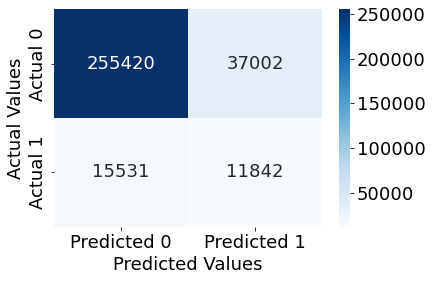

In [97]:
confusion_matrix_data(data,data.HeartDisease,model,0.6)

Forward Stepwise Selection 

*by Candy Tantichirasakul*

In [87]:
X = train_smote[['BMI', 'Smoking', 'AlcoholDrinking',"MentalHealth", "Stroke", "Sex",'PhysicalHealth', "DiffWalking", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer", "Age1", "Age2", "Age3", "Age4", "Age5", "Age6", "Age7", "Age8", "Age9", "Age10", "Age11", "Age12", "White", "Black", "Asian", "AmericanIndianAlaskanNative", "Hispanic", "Poor", "Fair", "Good", "Verygood"]]


In [88]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('HeartDisease~' + '+'.join(predictor_subset),data = train_smote).fit()
    llr_pvalue = model.llr_pvalue
    return {"model":model, "llr_pvalue":llr_pvalue}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [89]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [90]:
def forward_selection():
    models_best = pd.DataFrame(columns=["llr_pvalue", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [91]:
models_best = forward_selection()


Optimization terminated successfully.
         Current function value: 0.688846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689335
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684970
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660807
  

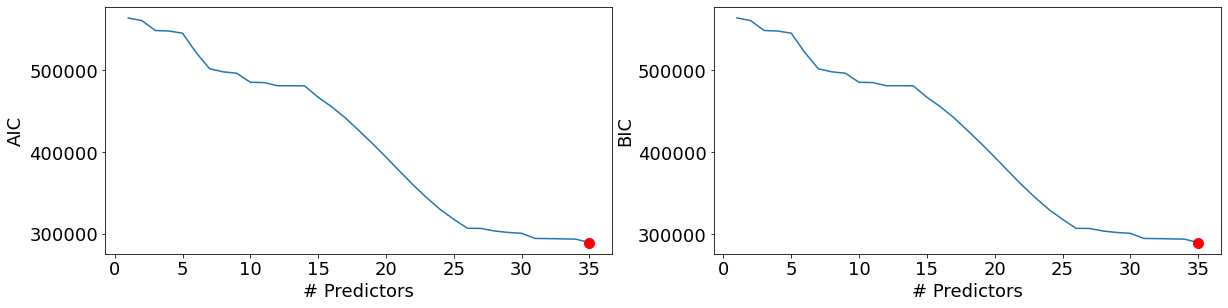

In [93]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    llr_pvalue = models_best.apply(lambda row: row[1].llr_pvalue, axis=1)

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 1)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [60]:
#Same as baseline model

Multicollinearity Analysis (VIF)

*by Candy Tantichirasakul*

In [64]:
X = train_smote[['BMI', 'Smoking', 'AlcoholDrinking', "Stroke", "Sex",'MentalHealth','PhysicalHealth', "DiffWalking", "Diabetic", "PhysicalActivity", "SleepTime", "Asthma", "KidneyDisease", "SkinCancer"]]


In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

             feature        VIF
0              const  55.036519
1                BMI   1.116572
2            Smoking   1.039083
3    AlcoholDrinking   1.018008
4             Stroke   1.030807
5                Sex   1.048794
6       MentalHealth   1.160585
7     PhysicalHealth   1.442182
8        DiffWalking   1.395057
9           Diabetic   1.100156
10  PhysicalActivity   1.220184
11         SleepTime   1.024032
12            Asthma   1.030675
13     KidneyDisease   1.038691
14        SkinCancer   1.013651


Interactions

*by Candy Tantichirasakul*

In [68]:
# Make dummies for categorical variables
# Replace columns with special characters "-", "/" or " "

def makeDummies(data):
    data = pd.concat([data, pd.get_dummies(data['Race'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['AgeCategory'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['GenHealth'])], axis=1)
    #remove last category to avoid multicollinearity
    data = data.drop(columns=['Race', 'Other','AgeCategory','80 or older', 'GenHealth', "Excellent"])
    data.rename(columns={"18-24": "Age1", "25-29": "Age2", "30-34": "Age3","35-39": "Age4","40-44": "Age5","45-49": "Age6","50-54": "Age7","55-59": "Age8","60-64": "Age9","65-69": "Age10","70-74": "Age11","75-79": "Age12"}, inplace = True)
    data.rename(columns={"Very good": "Verygood", "American Indian/Alaskan Native": "AmericanIndianAlaskanNative"}, inplace = True)
    return data

In [69]:
#Interaction between Asthma and Smoking
model2 = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)+(Verygood+Fair+Good+Poor)+Asthma*Smoking+Diabetic+KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()



Optimization terminated successfully.
         Current function value: 0.353174
         Iterations 9


Classification accuracy = 83.6%
Precision = 24.3%
TPR or Recall = 43.3%
FNR = 56.7%
FPR = 12.7%
ROC-AUC = 77.8%


0         0.025794
1         0.664184
2         0.695004
3         0.343466
4         0.007715
            ...   
319790    0.319479
319791    0.008490
319792    0.010996
319793    0.002273
319794    0.747911
Length: 319795, dtype: float64

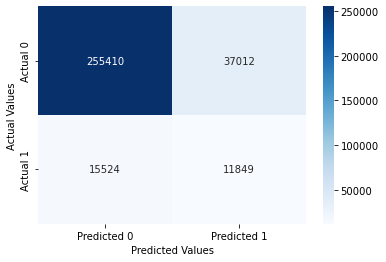

In [72]:
confusion_matrix_data(data,data.HeartDisease,model2,0.6)

In [74]:
#Interaction between Diabetic and Kidney
model3 = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)+(Verygood+Fair+Good+Poor)+Asthma+Smoking+Diabetic*KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.353077
         Iterations 9


Classification accuracy = 83.6%
Precision = 24.2%
TPR or Recall = 43.3%
FNR = 56.7%
FPR = 12.7%
ROC-AUC = 77.9%


0         0.025571
1         0.665195
2         0.693589
3         0.345723
4         0.007737
            ...   
319790    0.318036
319791    0.008662
319792    0.011061
319793    0.002280
319794    0.749544
Length: 319795, dtype: float64

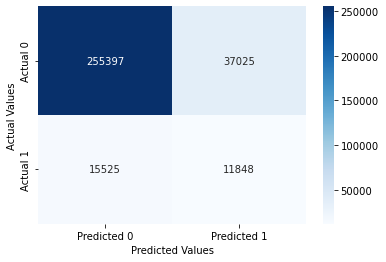

In [76]:
confusion_matrix_data(data,data.HeartDisease,model3,0.6)

In [77]:
#Interaction between both
model4 = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)+(Verygood+Fair+Good+Poor)+Asthma*Smoking+Diabetic*KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.353075
         Iterations 9


Classification accuracy = 83.6%
Precision = 24.2%
TPR or Recall = 43.3%
FNR = 56.7%
FPR = 12.7%
ROC-AUC = 77.9%


0         0.025165
1         0.664917
2         0.690009
3         0.345388
4         0.007730
            ...   
319790    0.314388
319791    0.008517
319792    0.011044
319793    0.002276
319794    0.749161
Length: 319795, dtype: float64

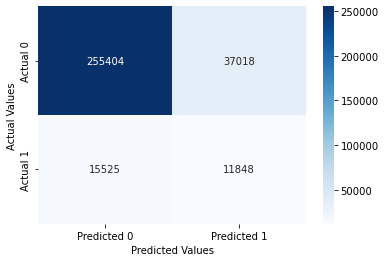

In [78]:
confusion_matrix_data(data,data.HeartDisease,model4,0.6)

In [81]:
#AgeCategory * GenHealth
model5 = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)*(Verygood+Fair+Good+Poor)+Asthma+Smoking+Diabetic+KidneyDisease+Stroke+Sex+AlcoholDrinking+DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.351447
         Iterations 9


Classification accuracy = 83.7%
Precision = 24.4%
TPR or Recall = 43.1%
FNR = 56.9%
FPR = 12.5%
ROC-AUC = 78.1%


0         0.023748
1         0.621006
2         0.665515
3         0.352514
4         0.005789
            ...   
319790    0.313019
319791    0.010676
319792    0.011606
319793    0.002057
319794    0.726488
Length: 319795, dtype: float64

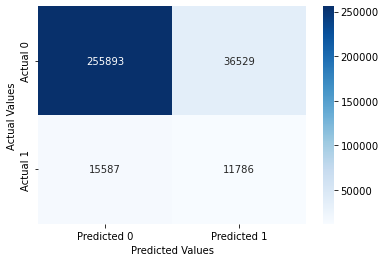

In [82]:
confusion_matrix_data(data,data.HeartDisease,model5,0.6)

In [85]:
#Stroke * Difficulty Walking
model6 = sm.logit(formula = 'HeartDisease~(Age1+Age2+Age3+Age4+Age5+Age6+Age7+Age8+Age9+Age10+Age11+Age12)+(Verygood+Fair+Good+Poor)+Asthma+Smoking+Diabetic+KidneyDisease+Sex+AlcoholDrinking+Stroke*DiffWalking+BMI+SkinCancer+MentalHealth+(White+Black+Asian+AmericanIndianAlaskanNative+Hispanic)+SleepTime+PhysicalActivity+PhysicalHealth', data = train_smote).fit()


Optimization terminated successfully.
         Current function value: 0.353114
         Iterations 9


Classification accuracy = 83.6%
Precision = 24.3%
TPR or Recall = 43.3%
FNR = 56.7%
FPR = 12.7%
ROC-AUC = 77.9%


0         0.026171
1         0.636488
2         0.699539
3         0.345168
4         0.007537
            ...   
319790    0.319094
319791    0.008650
319792    0.011036
319793    0.002284
319794    0.750241
Length: 319795, dtype: float64

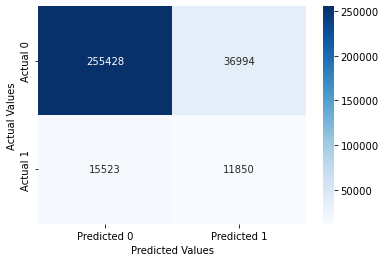

In [86]:
confusion_matrix_data(data,data.HeartDisease,model6,0.6)

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

Odds Analysis

*by Candy Tantichirasakul*

In [98]:
# Odds with unit increase in SleepTime
np.exp(model.params.SleepTime) - 1

-0.07006289186190962

In [100]:
# Odds with PhysicalActivity
np.exp(model.params.PhysicalActivity) - 1

-0.3521210784057902